In [34]:
using Pkg
if haskey(ENV,"COLAB_RELEASE_TAG")
  Pkg.add(url="https://github.com/emmacware/Droplets.jl")
  Pkg.add("CPUTime")
end
using Droplets, Random, CPUTime, Plots


   Resolving package versions...
    Updating `/Droplets.jl/Project.toml`
  [a9c8d775] + CPUTime v1.0.0
  No Changes to `/Droplets.jl/Manifest.toml`


In [35]:
FT = Float64

#coagsettings
Ns = 2^14
Δt = FT(1.0)
ΔV = FT(1e6)
golovin_kernel_coeff = FT(1.5e3)
kernel = golovin
n0 = FT(2^23)
R0 = FT(30.531e-6)

#runsettings
num_bins= 128
init_random_seed = 30
output_steps = [0,1200,2400,3600]
init_method = init_logarithmic
binning_method = mass_density_lnr

mass_density_lnr (generic function with 1 method)

In [36]:
coagsettings = coag_settings{FT}(
    Ns=Ns,
    Δt=Δt,
    ΔV=ΔV,
    golovin_kernel_coeff=golovin_kernel_coeff,
    n0=n0,
    R0=R0,
    kernel=kernel,
)
runsettings=run_settings{FT}(
    num_bins=num_bins,
    init_random_seed=init_random_seed,
    output_steps=output_steps,
    init_method=init_method,
    binning_method=binning_method,
)

run_settings{Float64}(128, [1.0e-5, 1.0497495645498898e-5, 1.1019741482726832e-5, 1.1567968822944827e-5, 1.2143470234613033e-5, 1.274760259090958e-5, 1.3381790268862351e-5, 1.4047528507636206e-5, 1.474638693389327e-5, 1.5480013262538644e-5  …  0.003229971392918577, 0.0033906610632248773, 0.003559344974656581, 0.003736420837228581, 0.0039223061468558335, 0.004117439169693268, 0.0043222799754461675, 0.004537311522087318, 0.004763040794538355, 0.004999999999999999], true, 2, 30, Serial(), none(), [0.0, 1200.0, 2400.0, 3600.0], Droplets.init_logarithmic, Droplets.mass_density_lnr, true)

In [37]:
function coag_runtime(randseed::Int,droplets::droplet_attributes,
    coag_settings::coag_settings{FT},run_settings::run_settings{FT}) where FT<:AbstractFloat

    Random.seed!(randseed)
    println("Running simulation...")

    coal_func_time::FT = 0.0
    bins::Matrix{FT} = zeros(FT, run_settings.num_bins, length(run_settings.output_steps))
    threading,scheme = run_settings.coag_threading, run_settings.scheme
    coag_data = coagulation_run{FT}(coag_settings.Ns)
    simtime::FT = @CPUelapsed begin
        for i  in  1:length(run_settings.output_steps)
            # if i,seconds in enumerate(run_settings.output_steps)

            if i !=1
                timestepper = (run_settings.output_steps[i]-run_settings.output_steps[i-1])/coag_settings.Δt
                ctime::FT = @CPUelapsed begin
                    for _ in 1:timestepper
                        coalescence_timestep!(threading,scheme,droplets,coag_data,coag_settings)
                    end
                end
                coal_func_time += ctime
            end
            bins[:,i] = binning_func(droplets,run_settings.output_steps[i],run_settings,coag_settings)
            # println("Time: ", run_settings.output_steps[i], " seconds")
        end
    end
    println("simtime =", simtime)
    println("coal_func_time =", coal_func_time)

    return bins, coal_func_time
end

coag_runtime (generic function with 1 method)

In [38]:
function plot_dsd(bins,runsettings::run_settings{FT};color="black",label=false,legend=true) where FT<:AbstractFloat
    radius_bins_edges = runsettings.radius_bins_edges
    mids = 0.5*(radius_bins_edges[1:end-1] + radius_bins_edges[2:end])*1e6
    plot1 = plot!(mids,bins,xaxis=:log,label= runsettings.output_steps',legend=legend,legendtitle="Time Steps (s)")
    xlabel!("Radius (μm)")
    if runsettings.binning_method == number_density
        ylabel!("Number density (m^-3)")
    elseif runsettings.binning_method == mass_density_lnr
        ylabel!("Mass density (kg m^-3)")
    end
    title!("Time Evolution of Droplet Size Distribution")

    return plot1
end

plot_dsd (generic function with 1 method)

Running simulation...
simtime =1.858728
coal_func_time =1.850069


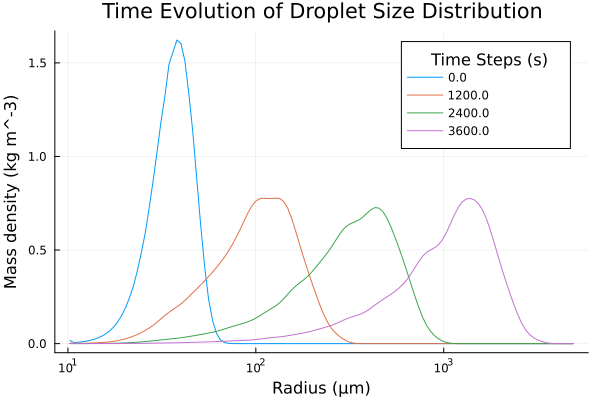

In [40]:
drops = runsettings.init_method(coagsettings)


bins,times = coag_runtime(1,drops,coagsettings,runsettings)
plot()
plot_dsd(bins*kg_to_g,runsettings)